<a href="https://colab.research.google.com/github/kimdesok/FinanceDataReader/blob/master/Stock_daily_COVID.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Short sell data and its relation to the price and returns of an example stock....

##1. Setting libraries and environment
> * importing libraries for data manipulation, graphics, trend indicator calculation, etc
> * Downloading stock data and preparing them for the further processing

In [ ]:
import urllib
import time
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
 
from urllib.request import urlopen
import seaborn as sns


In [ ]:
!pip install finance-datareader

#Ta-Lib library installation for calculating trend indicators

url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h516909a_0.tar.bz2'
!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
url = 'https://anaconda.org/conda-forge/ta-lib/0.4.19/download/linux-64/ta-lib-0.4.19-py37ha21ca33_2.tar.bz2'
!curl -L $url | tar xj -C /usr/local/lib/python3.7/dist-packages/ lib/python3.7/site-packages/talib --strip-components=3

import talib
import datetime

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3809    0  3809    0     0  19335      0 --:--:-- --:--:-- --:--:-- 19335
100  503k  100  503k    0     0  1043k      0 --:--:-- --:--:-- --:--:-- 1043k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3817    0  3817    0     0  23708      0 --:--:-- --:--:-- --:--:-- 23708
100  406k  100  406k    0     0   965k      0 --:--:-- --:--:-- --:--:-- 3535k



### Downloading the stock data

In [ ]:
!wget https://github.com/owid/covid-19-data/raw/master/public/data/owid-covid-data.csv

--2022-01-27 07:57:22--  https://github.com/owid/covid-19-data/raw/master/public/data/owid-covid-data.csv
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv [following]
--2022-01-27 07:57:22--  https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 44637780 (43M) [text/plain]
Saving to: ‘owid-covid-data.csv.1’

owid-covid-data.csv 100%[===================>]  42.57M   152MB/s    in 0.3s    

2022-01-27 07:57:23 (152 MB/s) - ‘owid-covid-data.csv.1’ saved [4463

In [ ]:
import FinanceDataReader as fdr
from datetime import date

my_file = '/content/owid-covid-data.csv'
short_df = pd.read_csv(my_file)
print(short_df.columns)

short_df = short_df[short_df['location']=='South Korea']


columns=['date', 'new_cases']
short_df= short_df[columns]

# sort the short sell data
short_df['Date'] = pd.to_datetime(short_df['date'])
short_df = short_df.pivot_table(index='Date', values=['new_cases'])
#short_df = short_df.sort_index()

#Set the beginning date for the analysis
print(short_df.index[0])
start_date = short_df.index[0]
end_date = short_df.index[-1] 
print('Displaying the data from ', start_date, 'to ', end_date, '\n')

print(short_df.head())
print(short_df.tail())

Index(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'new_tests', 'total_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'tests_units', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'total_boosters',
       'new_vaccinations', 'new_vaccinations_smoothed',
       't

In [ ]:
from numpy.core.numeric import ComplexWarning
# get stock codes from the company names
def get_codes(df, names):
  code_list = {}
  for name in names:
    code = df.query("names=='{}'".format(name))['codes'].to_string(index=False)
    code = code.strip()
    code_list[name] = code
  return code_list

my_file = '/content/drive/MyDrive/datasets/stock_codes.csv'
try:
  with open(my_file, 'r') as f:
    code_df = pd.read_csv(f)
    #print(type(code_df))
except:
  print("Make sure to mount the drive!")


#For this exercise, we need dataframes representing the stock perfromance of many companies.
Company_names = {'SK바이오사이언스':'SK Bioscience', '씨젠':'Seegene', '피씨엘':'PCL', '프레스티지바이오파마':'Prestige Biopharma', \
              '삼성전자':'Samsung','셀트리온':'Celltrion', '현대차':'Hyundai Automobile', \
              '대한항공':'Korean Air', '호텔신라':'Hotel Shilla' }
#Company_names = {'SK바이오사이언스':'SK Bioscience'}

code_list = get_codes(code_df, Company_names)
#print(code_list)

stock_list = {}
for name in Company_names:

# Load the stock market data from start_date to today
  
  stock_data = fdr.DataReader(code_list[name], start_date, end_date)

#Data transform using the closing price
  stock_data = stock_data.pivot_table(index='Date', values=['Close'])

  stock_data.columns = [Company_names[name]]

  #stock_data['Name'] = name

  stock_list[name] = stock_data
  stock_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 216 entries, 2021-03-18 to 2022-01-26
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   SK Bioscience  216 non-null    int64
dtypes: int64(1)
memory usage: 3.4 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 499 entries, 2020-01-23 to 2022-01-26
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   Seegene  499 non-null    int64
dtypes: int64(1)
memory usage: 7.8 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 499 entries, 2020-01-23 to 2022-01-26
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   PCL     499 non-null    int64
dtypes: int64(1)
memory usage: 7.8 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 242 entries, 2021-02-05 to 2022-01-26
Data columns (total 1 columns):
 #   Column              Non-Null Count  Dtype
---  ---

##2. Brief EDA
> * Calculate the correlation between the price and the short volume and balance

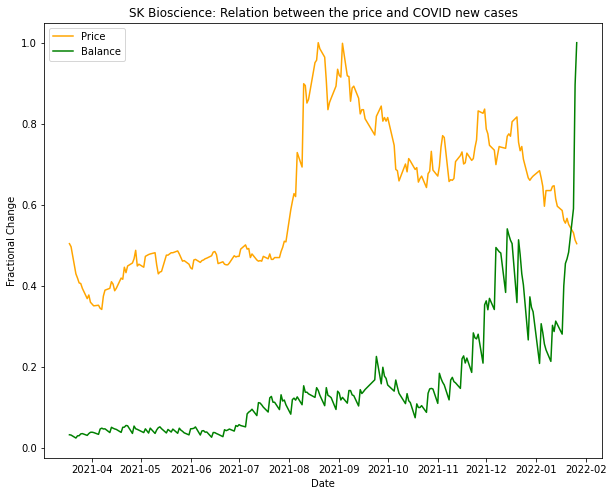

<Figure size 432x288 with 0 Axes>

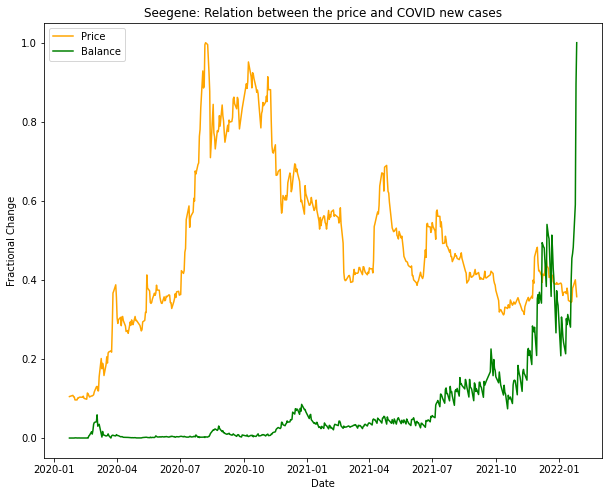

<Figure size 432x288 with 0 Axes>

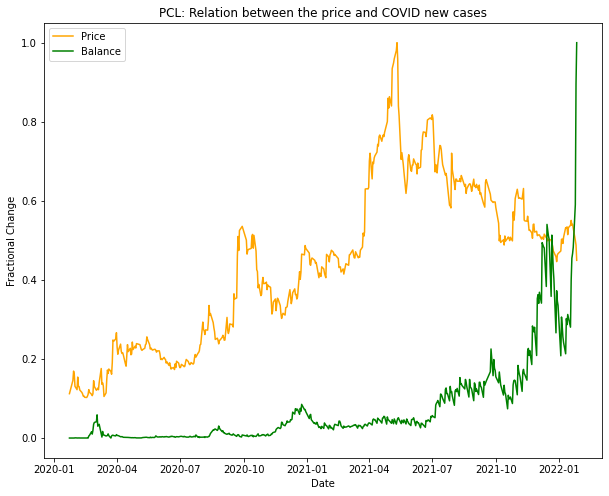

<Figure size 432x288 with 0 Axes>

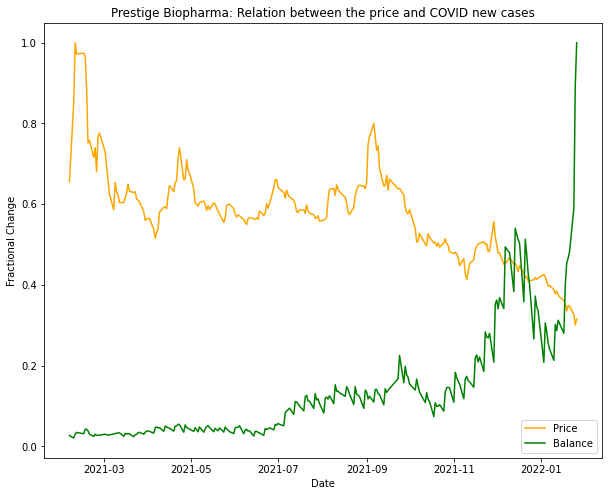

<Figure size 432x288 with 0 Axes>

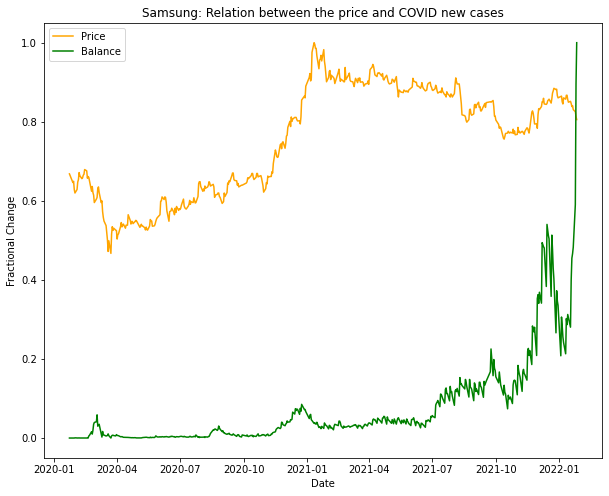

<Figure size 432x288 with 0 Axes>

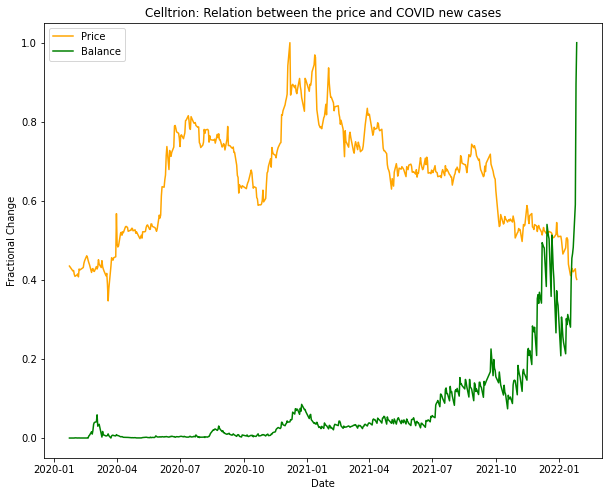

<Figure size 432x288 with 0 Axes>

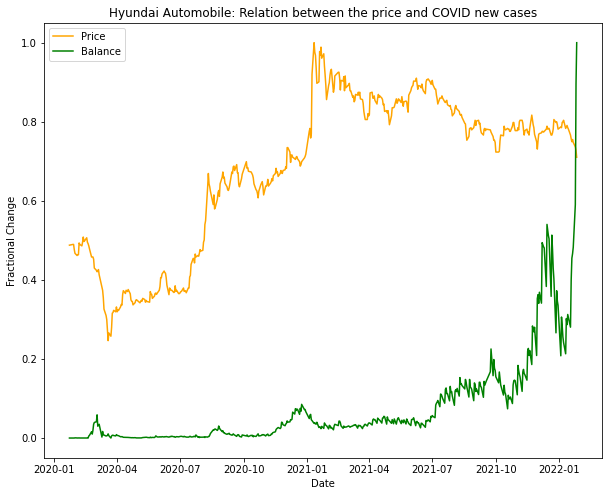

<Figure size 432x288 with 0 Axes>

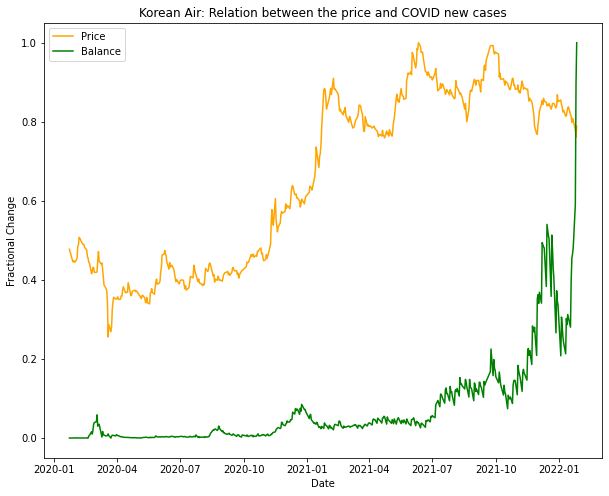

<Figure size 432x288 with 0 Axes>

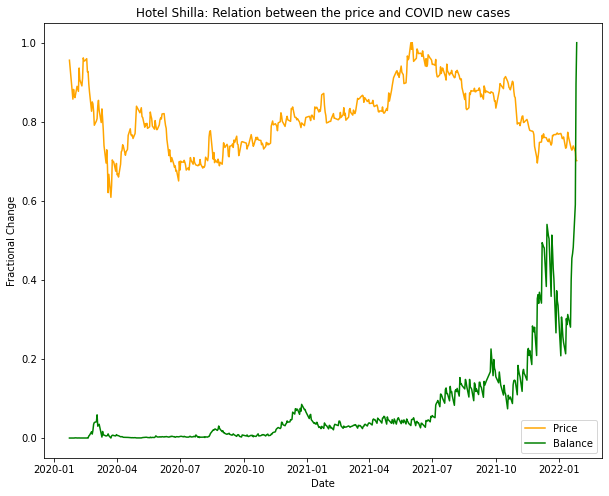

<Figure size 432x288 with 0 Axes>

In [ ]:
for key0 in Company_names:

  #Join stock and COVID dataframes
  full_df = pd.concat([stock_list[key0], short_df], axis=1).dropna()
  plt.figure(figsize = (10,8))

  plt.plot(full_df[Company_names[key0]]/full_df[Company_names[key0]].max(), color = 'orange', label ='Price')
  plt.plot(full_df['new_cases']/full_df['new_cases'].max(), color = 'green', label='Balance')


  plt.xlabel('Date')
  plt.ylabel('Fractional Change')
  plt.title(Company_names[key0] +': Relation between the price and COVID new cases')
  plt.legend()

  plt.show()  # show the plot

  plt.clf()  # clear the plot space


In [ ]:
#For US new cases

my_file = '/content/owid-covid-data.csv'
short_df = pd.read_csv(my_file)
print(short_df.columns)

short_df = short_df[short_df['location']=='United States']


columns=['date', 'new_cases']
short_df= short_df[columns]

# sort the short sell data
short_df['Date'] = pd.to_datetime(short_df['date'])
short_df = short_df.pivot_table(index='Date', values=['new_cases'])
#short_df = short_df.sort_index()

#Set the beginning date for the analysis
print(short_df.index[0])
start_date = short_df.index[0]
end_date = short_df.index[-1] 
print('Displaying the data from ', start_date, 'to ', end_date, '\n')

print(short_df.head())
print(short_df.tail())

Index(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'new_tests', 'total_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'tests_units', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'total_boosters',
       'new_vaccinations', 'new_vaccinations_smoothed',
       't

In [ ]:
#For US Companies

US_Companies= {'Bio-Rad Laboratories, Inc.':'BIO', 'Novavax, Inc.':'NVAX', 'Abbott Laboratories':'ABT', 'Quidel Corporation':'QDEL', \
               'Moderna, Inc.' : 'MRNA', 'Pfizer Inc. ':'PFE'}

US_stock_list = {}
for name, symbol in US_Companies.items():

# Load the stock market data from start_date to today
  
  stock_data = fdr.DataReader(symbol, start_date, end_date)

#Data transform using the closing price
  stock_data = stock_data.pivot_table(index='Date', values=['Close'])

  stock_data.columns = [name]

  #stock_data['Name'] = name

  US_stock_list[name] = stock_data
  stock_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 508 entries, 2020-01-23 to 2022-01-26
Data columns (total 1 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Bio-Rad Laboratories, Inc.  508 non-null    float64
dtypes: float64(1)
memory usage: 7.9 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 508 entries, 2020-01-23 to 2022-01-26
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Novavax, Inc.  508 non-null    float64
dtypes: float64(1)
memory usage: 7.9 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 508 entries, 2020-01-23 to 2022-01-26
Data columns (total 1 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Abbott Laboratories  508 non-null    float64
dtypes: float64(1)
memory usage: 7.9 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 508 e

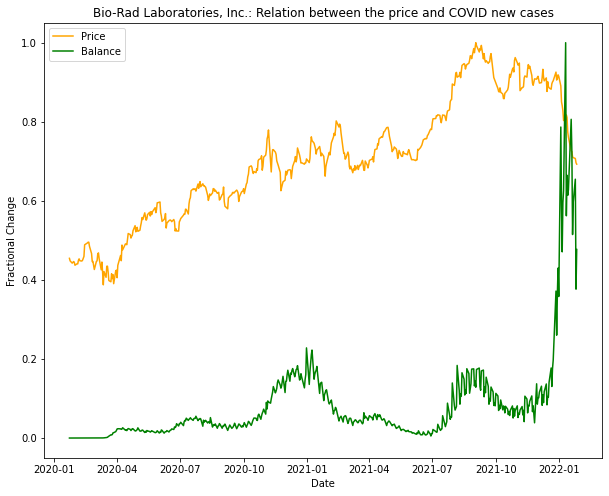

<Figure size 432x288 with 0 Axes>

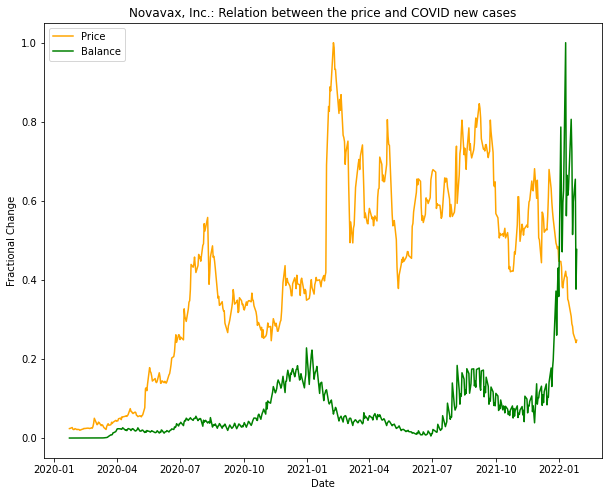

<Figure size 432x288 with 0 Axes>

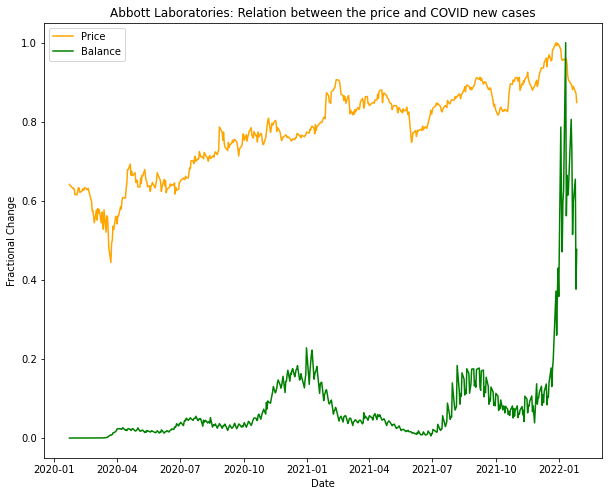

<Figure size 432x288 with 0 Axes>

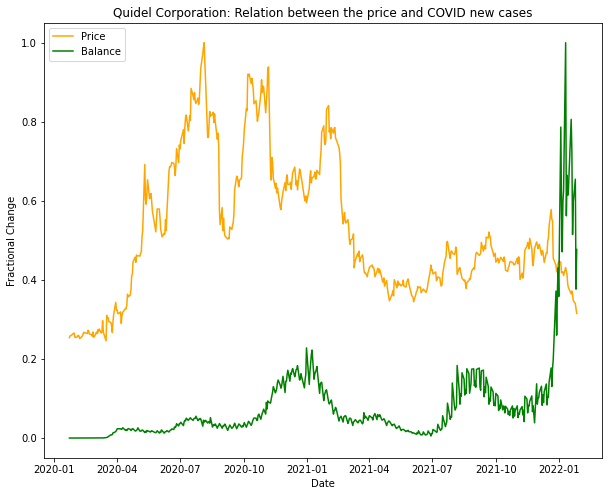

<Figure size 432x288 with 0 Axes>

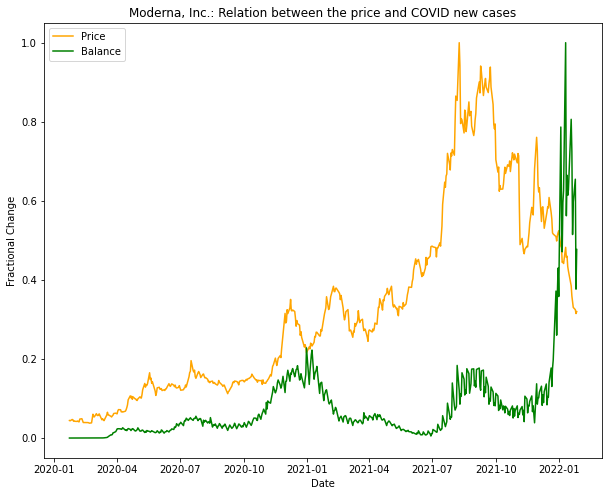

<Figure size 432x288 with 0 Axes>

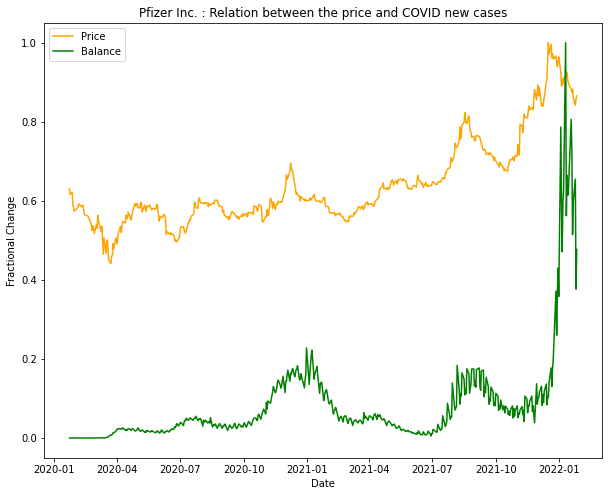

<Figure size 432x288 with 0 Axes>

In [ ]:
for key0, symbol in US_Companies.items():

  #Join stock and COVID dataframes
  full_df = pd.concat([US_stock_list[key0], short_df], axis=1).dropna()
  plt.figure(figsize = (10,8))

  plt.plot(full_df[key0]/full_df[key0].max(), color = 'orange', label ='Price')
  plt.plot(full_df['new_cases']/full_df['new_cases'].max(), color = 'green', label='Balance')


  plt.xlabel('Date')
  plt.ylabel('Fractional Change')
  plt.title(key0 +': Relation between the price and COVID new cases')
  plt.legend()

  plt.show()  # show the plot

  plt.clf()  # clear the plot space


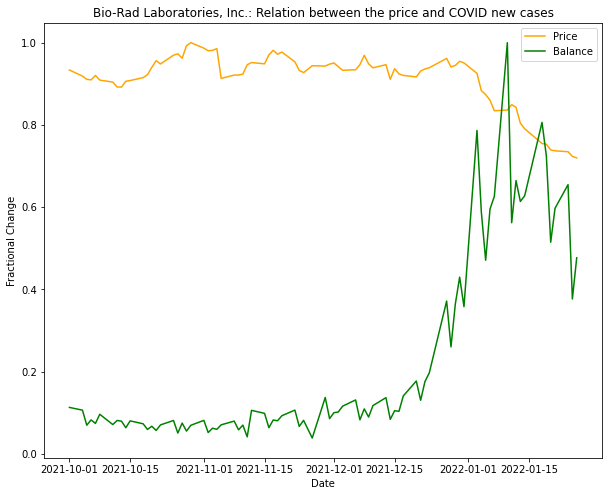

<Figure size 432x288 with 0 Axes>

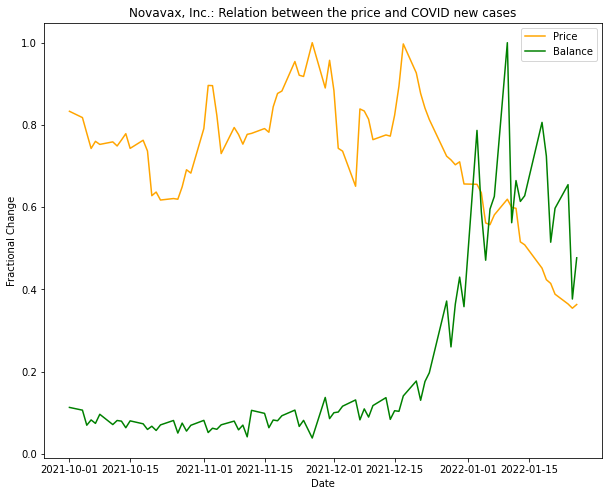

<Figure size 432x288 with 0 Axes>

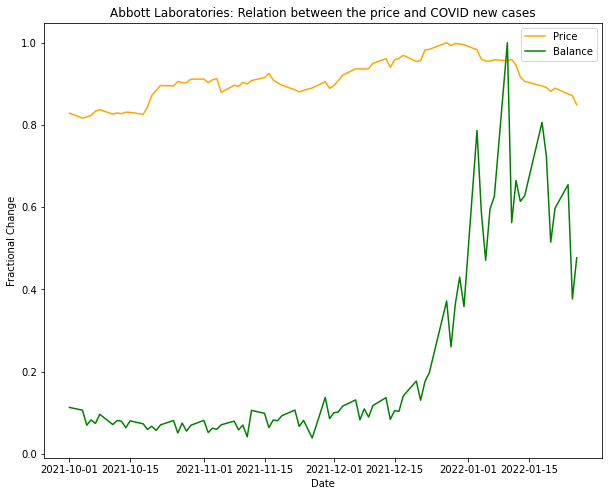

<Figure size 432x288 with 0 Axes>

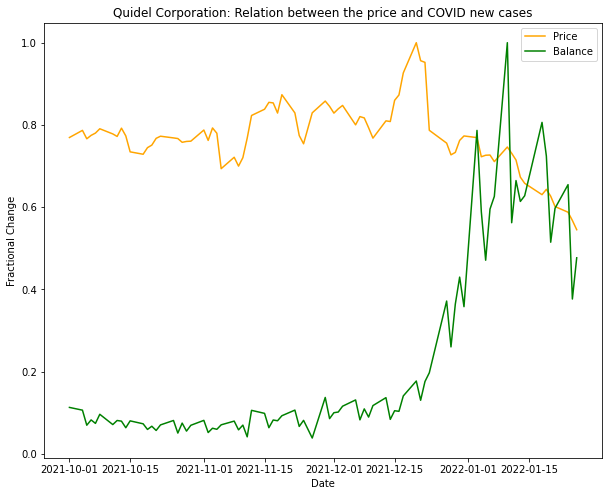

<Figure size 432x288 with 0 Axes>

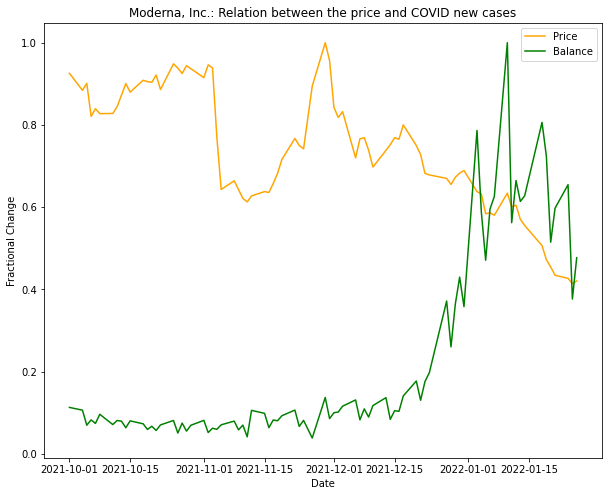

<Figure size 432x288 with 0 Axes>

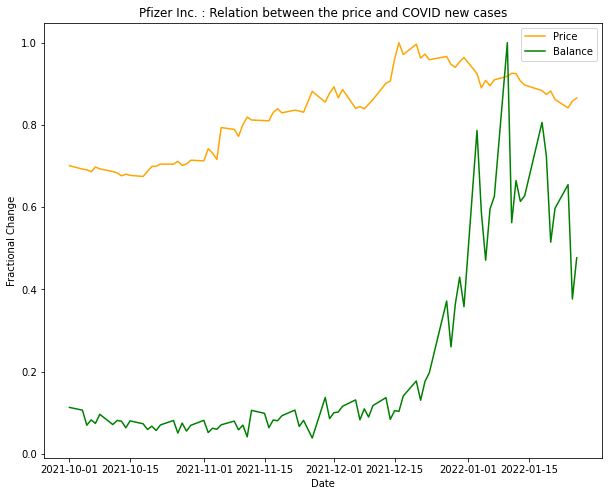

<Figure size 432x288 with 0 Axes>

In [ ]:
for key0, symbol in US_Companies.items():

  #Join stock and COVID dataframes
  full_df = pd.concat([US_stock_list[key0], short_df], axis=1)['2021-10-01':].dropna()
  plt.figure(figsize = (10,8))

  ax = plt.plot(full_df[key0]/full_df[key0].max(), color = 'orange', label ='Price')
  plt.plot(full_df['new_cases']/full_df['new_cases'].max(), color = 'green', label='Balance')

  #ax.axvspan('2021-12-15', alpha=0.3, color='red') 

  plt.xlabel('Date')
  plt.ylabel('Fractional Change')
  plt.title(key0 +': Relation between the price and COVID new cases')
  plt.legend()

  plt.show()  # show the plot

  plt.clf()  # clear the plot space